# Imports and utility functions

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = '/workspace'
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from pathlib import Path

In [ ]:
def load_training_labels(data_dir='./', num_samples=None, balanced=False):
    training_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
    training_labels['label'] = training_labels['label'].astype('bool')
    if num_samples is None:
        return training_labels.sample(frac=1).reset_index(drop=True)
    
    if balanced:
        pos = training_labels[training_labels['label']].sample(num_samples // 2)
        neg = training_labels[~training_labels['label']].sample(num_samples // 2)
        training_labels = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
    else:
        training_labels = training_labels.sample(num_samples).reset_index(drop=True)

    return training_labels


def get_training_images(training_labels, data_dir='./', color_mode='rgb', crop=1.0):
    images = np.array(
        [tf.image.central_crop(
            keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'train', f'{id}.tif'), color_mode=color_mode)),
            crop).numpy()
         for id in training_labels['id']])
    return images


def batch_image_generator(training_labels, batch_size):
    inp = list(training_labels.index)
    while True:
        random.shuffle(inp)
        for i in range(0, len(inp), batch_size):
            inds = inp[i:i+batch_size]
            batch_labels = training_labels.loc[inds].reset_index(drop=True)
            batch_images = get_training_images(batch_labels)
            yield batch_images, batch_labels['label']


def stochastic_batch_image_generator(training_labels, batch_size):
    while True:
        batch_labels = training_labels.sample(batch_size).reset_index(drop=True)
        ids = batch_labels['id']
        batch_images = get_training_images(batch_labels)
        yield batch_images, batch_labels['label']


def get_test_images(data_dir='./', color_mode='rgb', crop=1.0):
    test_image_files = [f for f in os.listdir(os.path.join(data_dir, "test")) if f.endswith(".tif")]
    test_ids = [Path(f).stem for f in test_image_files]
    test_images = np.array(
        [tf.image.central_crop(
            keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'test', f), color_mode=color_mode)),
            crop).numpy()
         for f in test_image_files])
    return test_images, test_ids


def generate_submission(model, test_images, test_ids, color_mode='rgb', output_file='submission.csv'):
    test_predictions = model.predict(test_images)
    submission = pd.DataFrame({"id": test_ids, "label": test_predictions.flatten()})
    submission.to_csv(output_file, index=False)


def plot_training_history(history):
    # Plot the training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Problem Description

The challenge is to build CNN models to identify whether there are cancer cells in small image patches taken from larger pathology scans. The images in the dataset are 96x96 pixels in size with 3 color channels and are taken from the PCam dataset. The dataset is from the kaggle competition https://www.kaggle.com/competitions/histopathologic-cancer-detection and the task is to identify whether there is atleast one pixel of tumor tissue in the center 32x32 pixels of the image.

There are 220,025 training images and 57,458 test images. The training images are labeled as 0 or 1, where 0 indicates no tumor pixels and 1 indicates atleast one tumor pixel. The test images are unlabeled.




# Exploratory Data Analysis (EDA)


In [24]:
# Read the training labels
training_labels = load_training_labels(data_dir)
print(training_labels.shape)
print(training_labels.head())
print(training_labels['label'].value_counts())


(220025, 2)
                                         id  label
0  6d1c22f1b38d253fc0e1d0b7f1a56173f28ca634   True
1  7281e23a8002fc98d648630c579a9985afe0d802   True
2  5d8b012760b8eaac1454af9d648f335ef5244da8  False
3  527d27a71815fa40143bc5ebf1c2418c5bc2d907  False
4  393be8758fac0a66124e7eab7ef34dee16e4196c   True
label
False    130908
True      89117
Name: count, dtype: int64


From the above output, we can see that the training data has 130908 images without tumor tissue and 89117 images with tumor tissue. The dataset is slightly imbalanced.


Visualizing a few sample images from the training dataset. 

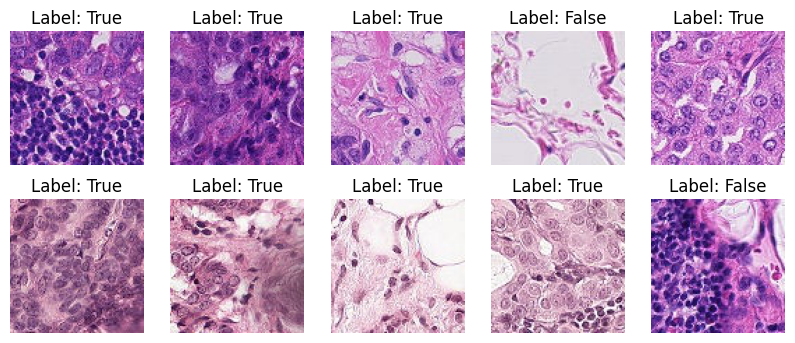

In [25]:
sample_training_labels = training_labels.sample(10)
sample_images = get_training_images(sample_training_labels, data_dir)
sample_labels = sample_training_labels['label']

plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Since the problem is to look at tumor tissues in the center 32x32 pixels of the image, let's crop and visualize the center of the images

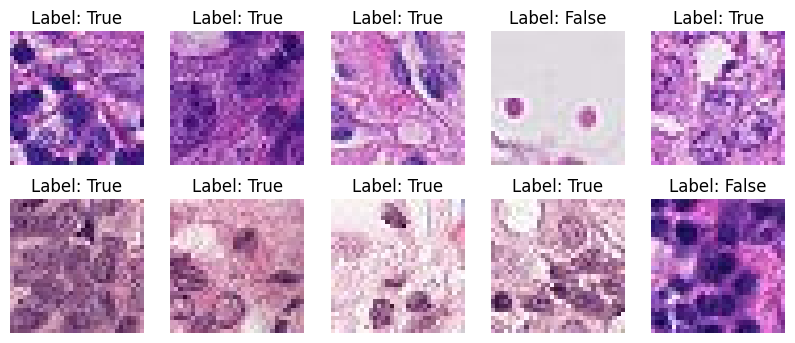

In [ ]:
cropped_images = get_training_images(sample_training_labels, data_dir, crop=1/3)
plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(cropped_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Also looking at a few images in greyscaleale both the full images and the cropped 32x32 center patches.

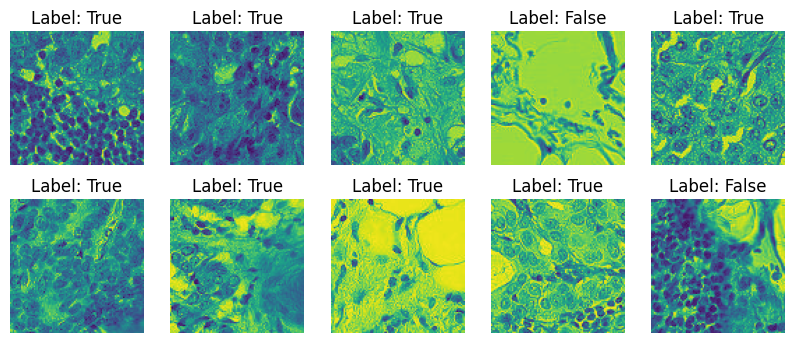

In [27]:
sample_images = get_training_images(sample_training_labels, data_dir, color_mode='grayscale')
sample_labels = sample_training_labels['label']
plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()




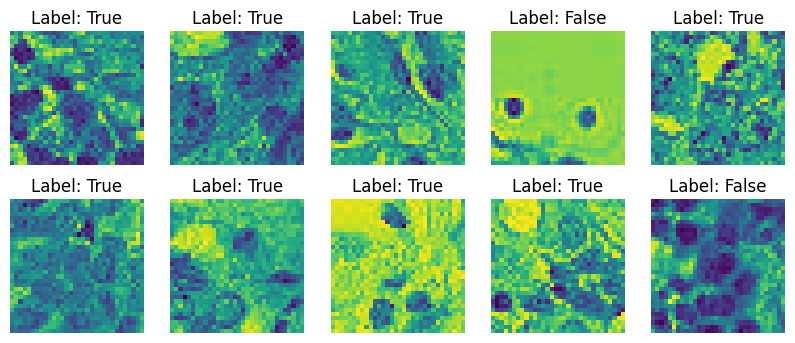

In [ ]:
cropped_images = get_training_images(sample_training_labels, data_dir, color_mode='grayscale', crop=1/3)

plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

The plan is to train CNN based models on the 32x32 center patches with color information and also on just the grayscale images. We will compare the results of the two 
models to see whether color information is useful for this task.

I also plan to try a few different model architectures to see which one performs the best. And also try to see how the models scale with the number of training samples used.

I also plan to see if using the full 96x96 patches makes any difference to the results.

### TODO
Add more visualizations and data analysis

# Model building and tuning

I will start with a simple CNN based model with one fully connected layer at the end for classification. I will use all the training images and use a fraction of them as validation set. I will just use the 32x32 center patches to start with color information.

In [ ]:
# Prepare the training data
X = get_training_images(training_labels, data_dir, crop=1/3)
y = training_labels['label'].values

print(X.shape)
print(y.shape)


(220025, 32, 32, 3)
(220025,)


In [ ]:
test_images, test_ids = get_test_images(data_dir, crop=1/3)
print(test_images.shape)

(57458, 32, 32, 3)


Below is a little helper function to train a model and generate submission file. I am going to create a few models, execute them and compare the results.

In [34]:
def train_model_and_generate_submission(model, model_name, epochs=100, batch_size=32, validation_split=0.2):
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1,
        monitor='val_AUC',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        verbose=1,
        monitor='val_AUC',
        mode='max')

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    model.load_weights(f'{model_name}.best_weights.keras')
    generate_submission(model, test_images, test_ids, output_file=f'submission_{model_name}.csv')
    return model, history
    

For the first model, I will use a few groups with a convolution layers and a pooling layer followed by a single fully connected hidden layer for classification. 
The convolution layers will do the feature extraction and then the final FC hidden layer will do the classification.
I will use sigmoid for the output layer since this is a binary classification problem and ReLU activation for all the other layers.
I am using binary crossentropy as the loss function and ADAM as the optimizer. I am tracking AUC as this competition uses AUC (Area Under the Curve) for scoring.

In [35]:
model1 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,729 (3.49 MB)

 Trainable params: 913,729 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model1, history = train_model_and_generate_submission(model1, 'cnn_4_layers_fc_1_layer_without_normalization')

Epoch 1/100
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8028 - accuracy: 0.7472 - loss: 0.8673 
Epoch 1: val_AUC improved from -inf to 0.83738, saving model to cnn_4_layers_fc_1_layer_without_normalization.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8028 - accuracy: 0.7472 - loss: 0.8672 - val_AUC: 0.8374 - val_accuracy: 0.7640 - val_loss: 0.4992
Epoch 2/100
5482/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8491 - accuracy: 0.7835 - loss: 0.4720 
Epoch 2: val_AUC improved from 0.83738 to 0.85388, saving model to cnn_4_layers_fc_1_layer_without_normalization.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.8491 - accuracy: 0.7835 - loss: 0.4720 - val_AUC: 0.8539 - val_accuracy: 0.7864 - val_loss: 0.4633
Epoch 3/100
5495/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8654 - accuracy: 0.7972 - loss: 0.4471 
Epoch 3: val_AUC improved from 0.85388 to 0.87278, saving model to cnn_4_layers_fc_1_layer_without_normalization.best_weigh

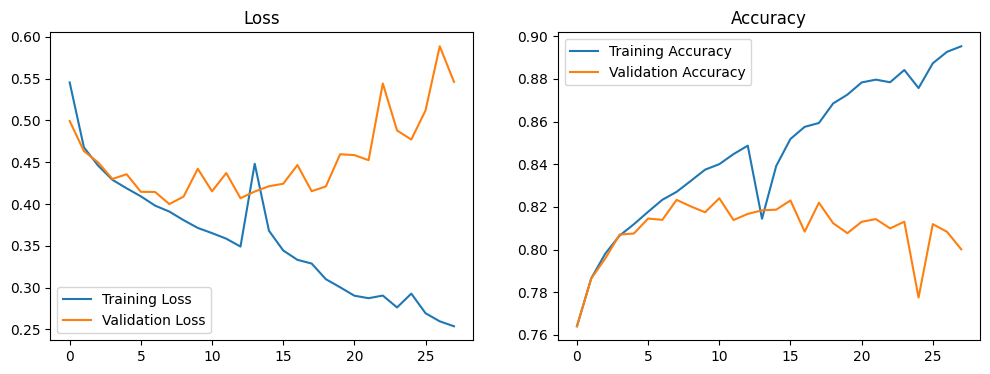

In [37]:
plot_training_history(history)

I am modifying the previous model and added a rescaling layer to scale the image data from 0-255 to 0-1 and apply BatchNormalization at the end of each convolution layer and after the FC hidden layer and also increased the number of unit in FC hidden layer to 1024.

In [38]:
model2 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445,057 (5.51 MB)

 Trainable params: 1,442,049 (5.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [39]:
model2, history = train_model_and_generate_submission(model2, 'cnn_4_layers_fc_1_layer_batch_normalization', batch_size=512)

Epoch 1/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8318 - accuracy: 0.7728 - loss: 0.5790
Epoch 1: val_AUC improved from -inf to 0.69235, saving model to cnn_4_layers_fc_1_layer_batch_normalization.best_weights.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 0.8319 - accuracy: 0.7729 - loss: 0.5787 - val_AUC: 0.6923 - val_accuracy: 0.4473 - val_loss: 2.1691
Epoch 2/100
340/344 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8988 - accuracy: 0.8304 - loss: 0.3888
Epoch 2: val_AUC improved from 0.69235 to 0.88290, saving model to cnn_4_layers_fc_1_layer_batch_normalization.best_weights.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8988 - accuracy: 0.8304 - loss: 0.3887 - val_AUC: 0.8829 - val_accuracy: 0.7656 - val_loss: 0.4822
Epoch 3/100
338/344 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9156 - accuracy: 0.8476 - loss: 0.3570
Epoch 3: val_AUC improved from 0.88290 to 0.89371, saving model to cnn_4_layers_fc_1_layer_batch_normalization.best_weights.keras
344/344 ━

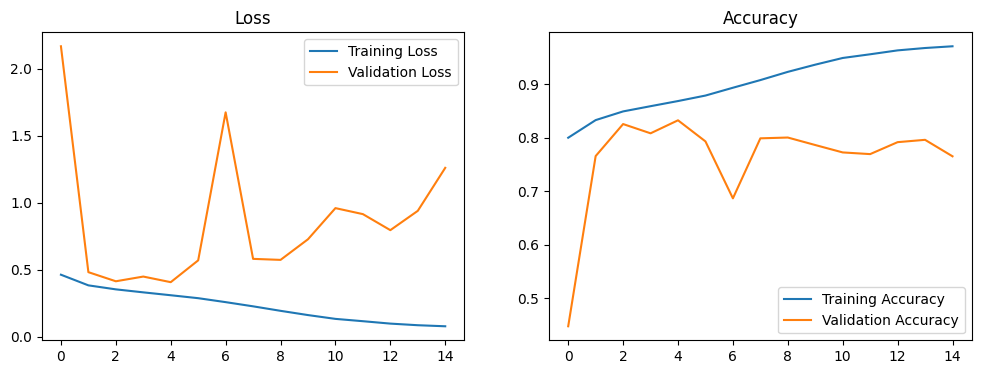

In [40]:
plot_training_history(history)

In [41]:
model3 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,673 (6.49 MB)

 Trainable params: 1,700,673 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model3, history = train_model_and_generate_submission(model3, 'cnn_4_layers_fc_2_layer_dropout', batch_size=128)

Epoch 1/100
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8111 - accuracy: 0.7495 - loss: 0.5167

2025-04-08 12:58:05.438849: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 136 bytes spill stores, 136 bytes spill loads

2025-04-08 12:58:05.479748: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121_0', 136 bytes spill stores, 136 bytes spill loads

2025-04-08 12:58:05.550510: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 84 bytes spill stores, 156 bytes spill loads

2025-04-08 12:58:05.624632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_121', 340 bytes spill stores, 340 bytes spill loads

2025-04-08 12:58:05.628846: I exter


Epoch 1: val_AUC improved from -inf to 0.86082, saving model to cnn_4_layers_fc_2_layer_dropout.best_weights.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - AUC: 0.8111 - accuracy: 0.7495 - loss: 0.5167 - val_AUC: 0.8608 - val_accuracy: 0.7756 - val_loss: 0.4736
Epoch 2/100
1359/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8681 - accuracy: 0.8015 - loss: 0.4430
Epoch 2: val_AUC improved from 0.86082 to 0.88129, saving model to cnn_4_layers_fc_2_layer_dropout.best_weights.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8682 - accuracy: 0.8015 - loss: 0.4429 - val_AUC: 0.8813 - val_accuracy: 0.8095 - val_loss: 0.4215
Epoch 3/100
1368/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8826 - accuracy: 0.8145 - loss: 0.4195
Epoch 3: val_AUC improved from 0.88129 to 0.89353, saving model to cnn_4_layers_fc_2_layer_dropout.best_weights.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8826 - accuracy: 0.8145 - loss: 0.4195 - val_AUC: 0.8935 - val_accuracy: 0.8205 - val_

2025-04-08 12:59:31.996834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 60 bytes spill stores, 60 bytes spill loads

2025-04-08 12:59:32.091520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 84 bytes spill stores, 156 bytes spill loads

2025-04-08 12:59:32.095662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 20 bytes spill stores, 20 bytes spill loads

2025-04-08 12:59:32.129100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 200 bytes spill stores, 200 bytes spill loads

2025-04-08 12:59:32.158385: I external/local_

1750/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step

2025-04-08 12:59:35.170183: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 12:59:35.240546: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 228 bytes spill stores, 252 bytes spill loads

2025-04-08 12:59:35.241968: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 36 bytes spill stores, 36 bytes spill loads

2025-04-08 12:59:35.261179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 48 bytes spill stores, 48 bytes spill loads

2025-04-08 12:59:35.266146: I external/local_xla

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step  


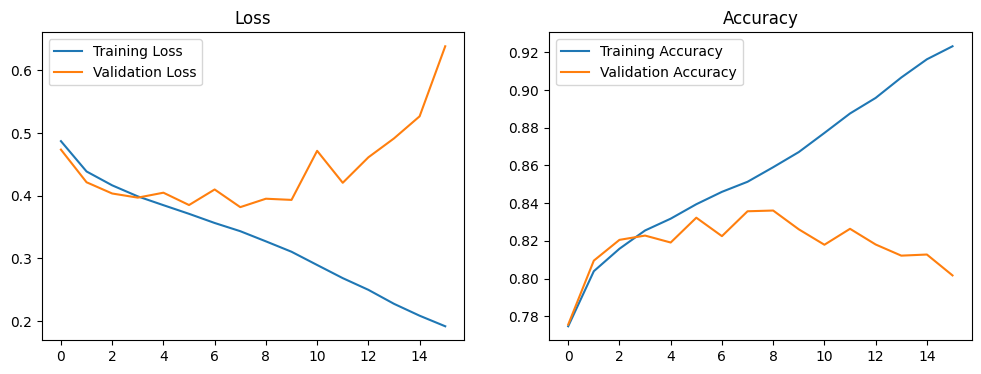

In [43]:
plot_training_history(history)

In [67]:
model4 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(48, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(48, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(),
               metrics=['AUC', 'accuracy'])
model4.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 32, 32, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 16, 16, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 16, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,929,057 (7.36 MB)

 Trainable params: 1,929,057 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model4, history = train_model_and_generate_submission(model4, 'cnn_3_2_layers_fc_2_layer_dropout', batch_size=32)

Epoch 1/100
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8051 - accuracy: 0.7460 - loss: 0.1331 
Epoch 1: val_AUC improved from -inf to 0.86456, saving model to cnn_3_2_layers_fc_2_layer_dropout.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - AUC: 0.8051 - accuracy: 0.7460 - loss: 0.1331 - val_AUC: 0.8646 - val_accuracy: 0.7955 - val_loss: 0.1189
Epoch 2/100
5499/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8679 - accuracy: 0.8011 - loss: 0.1147 
Epoch 2: val_AUC improved from 0.86456 to 0.88225, saving model to cnn_3_2_layers_fc_2_layer_dropout.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - AUC: 0.8679 - accuracy: 0.8011 - loss: 0.1147 - val_AUC: 0.8823 - val_accuracy: 0.8110 - val_loss: 0.1092
Epoch 3/100
5487/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8840 - accuracy: 0.8153 - loss: 0.1081 
Epoch 3: val_AUC improved from 0.88225 to 0.89798, saving model to cnn_3_2_layers_fc_2_layer_dropout.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━

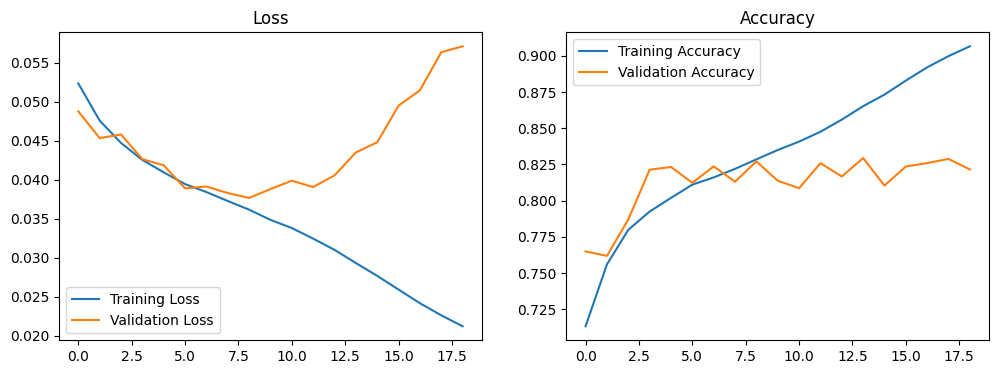

In [47]:
plot_training_history(history)

In [69]:
model5 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(48, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(48, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               #loss='binary_crossentropy',
               loss=keras.losses.BinaryFocalCrossentropy(),
               metrics=['AUC', 'accuracy'])
model5.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 32, 32, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 16, 16, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 16, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,961 (9.69 MB)

 Trainable params: 2,537,921 (9.68 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [70]:
model5, history = train_model_and_generate_submission(model5, 'cnn_3_2_layers_fc_2_layer_batch', batch_size=32)

Epoch 1/100
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8030 - accuracy: 0.7464 - loss: 0.1585 
Epoch 1: val_AUC improved from -inf to 0.81967, saving model to cnn_3_2_layers_fc_2_layer_batch.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - AUC: 0.8030 - accuracy: 0.7464 - loss: 0.1585 - val_AUC: 0.8197 - val_accuracy: 0.7583 - val_loss: 0.1578
Epoch 2/100
5486/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8724 - accuracy: 0.8060 - loss: 0.1129 
Epoch 2: val_AUC improved from 0.81967 to 0.88363, saving model to cnn_3_2_layers_fc_2_layer_batch.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - AUC: 0.8724 - accuracy: 0.8061 - loss: 0.1129 - val_AUC: 0.8836 - val_accuracy: 0.7928 - val_loss: 0.1217
Epoch 3/100
5490/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8959 - accuracy: 0.8291 - loss: 0.1030 
Epoch 3: val_AUC improved from 0.88363 to 0.90307, saving model to cnn_3_2_layers_fc_2_layer_batch.best_weights.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 19

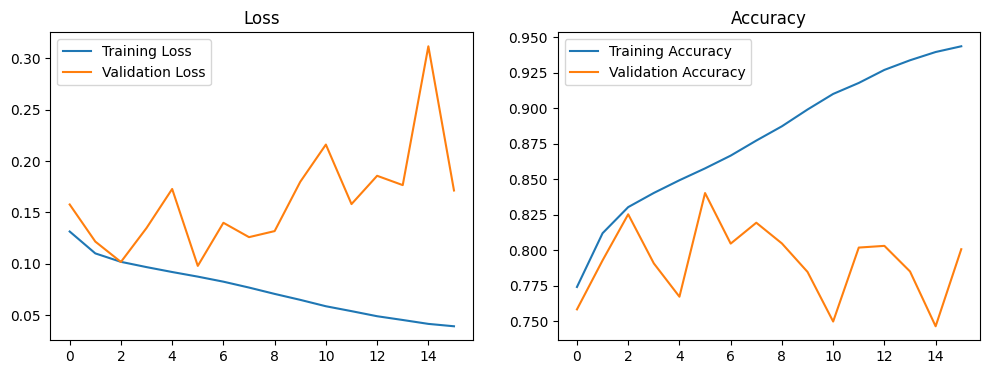

In [71]:
plot_training_history(history)

In [8]:
model6 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(48, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(80, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(96, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(96, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(112, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(144, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(160, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')
])

model6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(),
               metrics=['AUC', 'accuracy'])
model6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 80)     │        46,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 96)     │        69,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 112)      │        96,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 128)      │       129,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 144)      │       166,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 4, 4, 160)      │       207,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,977 (5.41 MB)

 Trainable params: 1,418,977 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6, history = train_model_and_generate_submission(model6, 'cnn_3_3_layers_fc_2_layer_batch', batch_size=32)

In [ ]:
plot_training_history(history)

In [10]:
base_model = keras.applications.EfficientNetV2B0(
    weights=None,
    input_shape=(96, 96, 3),
    include_top=False)

# base_model.summary()

model7 = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model7.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(),
               metrics=['AUC', 'accuracy'])
model7.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 3, 3, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,232,081 (27.59 MB)

 Trainable params: 7,171,473 (27.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
model7, history = train_model_and_generate_submission(model7, 'efficientnetv2b0_fc_1_layer', batch_size=32)

In [ ]:
plot_training_history(history)

# Results and Analysis

# Conclusion